# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [51]:
# MY CODE BELOW: 

# Import all the necessary libraries for this assignment: 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import cross_val_score
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
import seaborn as sns




In [2]:
# Import necessary libraries
# import pandas as pd

# Define column names
columns = ['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area']

# Load the dataset
fires_df = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))



In [3]:
# Have an overview of the data
fires_df.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
# Inspect data structure
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [5]:
# See basic statistics
fires_df.describe()

,coord_x,coord_y,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


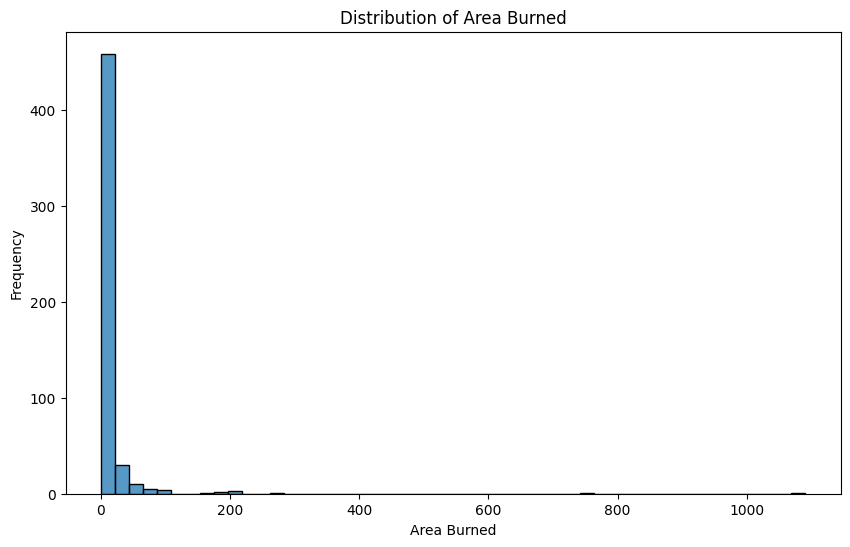

In [55]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(fires_df['area'], kde=False, bins=50)
plt.title('Distribution of Area Burned')
plt.xlabel('Area Burned')
plt.ylabel('Frequency')
plt.show()


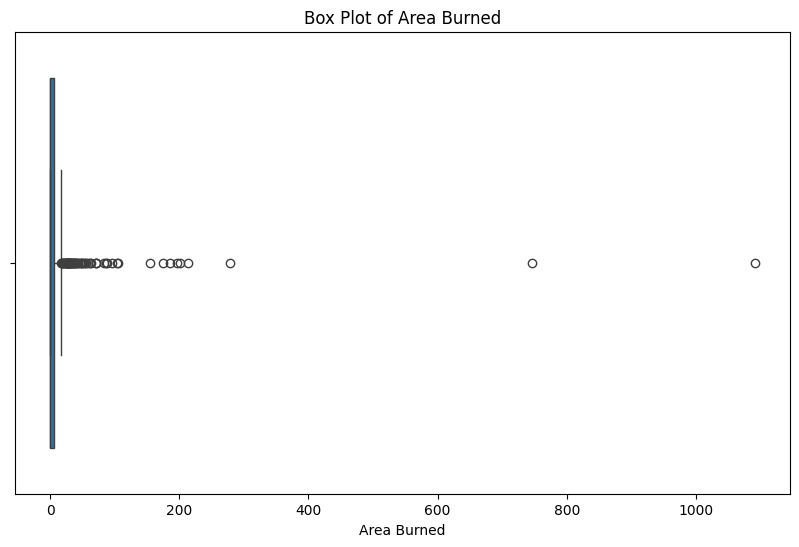

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=fires_df['area'])
plt.title('Box Plot of Area Burned')
plt.xlabel('Area Burned')
plt.show()


In [61]:
# Sort the DataFrame by 'area' in descending order and get the top 10 values
top_10_areas = fires_df.nlargest(10, 'area')

# Display the top 10 values of 'area'
print(top_10_areas[['area']])

        area
238  1090.84
415   746.28
479   278.53
237   212.88
236   200.94
235   196.48
420   185.76
377   174.63
234   154.88
233   105.66


In [62]:
# Drop rows by index
fires_df_dropped = fires_df.drop([238, 415])

# Verify the rows have been dropped
print(fires_df_dropped[['area']].nlargest(10, 'area'))


       area
479  278.53
237  212.88
236  200.94
235  196.48
420  185.76
377  174.63
234  154.88
233  105.66
232  103.39
231   95.18


# Get X and Y

Create the features data frame and target data.

In [63]:
# import numpy as np

# Apply log transformation to the target variable
# Get X and log-transformed y
X = fires_df_dropped.drop(columns=['area'])   # Features data frame (remove the target column)
y = np.log1p(fires_df_dropped['area'])        # Log-transformed target data



# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [64]:
# Import necessary libraries
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer


numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [65]:

# Preprocessor 1: Standard scaling + One-Hot Encoding
preproc1 = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),                                
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [66]:
# Import necessary libraries
# from sklearn.pipeline import Pipeline

# Preprocessor 2: Standard scaling + One-Hot Encoding + Non-linear transformation
preproc2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('power', PowerTransformer())
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [67]:
# Import necessary libraries
# from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import Lasso, Ridge
# from sklearn.ensemble import RandomForestRegressor

# Define baseline and advanced regressors
baseline_regressor = KNeighborsRegressor()
advanced_regressor = RandomForestRegressor(random_state=42)

In [68]:
# Pipeline A: preproc1 + baseline (KNN)
pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', baseline_regressor)
])


In [69]:
# Pipeline B: preproc2 + baseline (KNN)
pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', baseline_regressor)
])


In [70]:
# Pipeline C: preproc1 + advanced (Random Forest)
pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', advanced_regressor)
])



In [71]:
# Pipeline D: preproc2 + advanced (Random Forest)
pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', advanced_regressor)
])

In [72]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


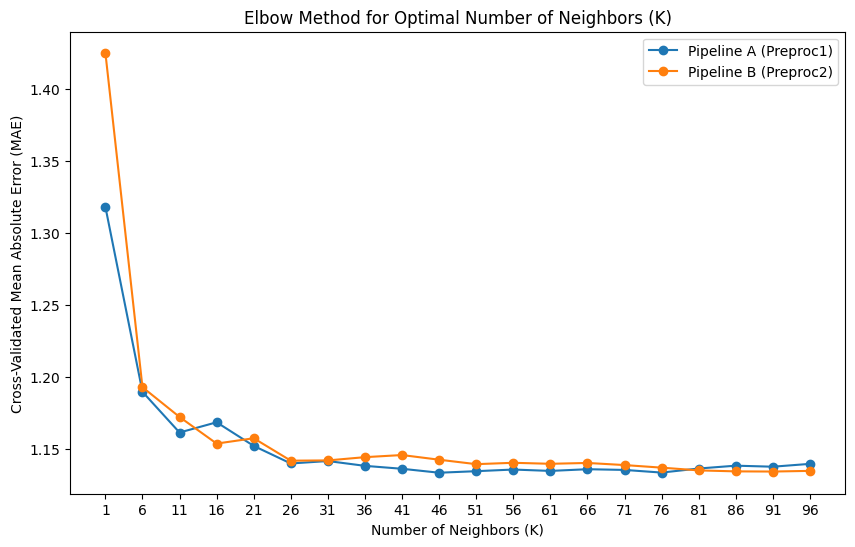

In [73]:
# from sklearn.model_selection import cross_val_score
# import matplotlib.pyplot as plt

# Define a range for `n_neighbors` to evaluate
n_neighbors_range = range(1, 100, 5)
errors_A, errors_B = [], []

# Loop through each value of n_neighbors for both pipelines
for n in n_neighbors_range:
    # Define KNN for Pipeline A and B with variable `n_neighbors`
    knn_A = KNeighborsRegressor(n_neighbors=n)
    knn_B = KNeighborsRegressor(n_neighbors=n)
    
    # Define Pipeline A with `preproc1` and Pipeline B with `preproc2`
    elbow_pipeline_A = Pipeline([
        ('preprocessing', preproc1),
        ('regressor', knn_A)
    ])
    
    elbow_pipeline_B = Pipeline([
        ('preprocessing', preproc2),
        ('regressor', knn_B)
    ])
    
    # Perform cross-validation for Pipeline A
    mae_scores_A = -cross_val_score(elbow_pipeline_A, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    errors_A.append(np.mean(mae_scores_A))
    
    # Perform cross-validation for Pipeline B
    mae_scores_B = -cross_val_score(elbow_pipeline_B, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    errors_B.append(np.mean(mae_scores_B))

# Plot the elbow curves for both pipelines
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_range, errors_A, label="Pipeline A (Preproc1)", marker='o')
plt.plot(n_neighbors_range, errors_B, label="Pipeline B (Preproc2)", marker='o')
plt.title("Elbow Method for Optimal Number of Neighbors (K)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Cross-Validated Mean Absolute Error (MAE)")
plt.xticks(n_neighbors_range)
plt.legend()
plt.show()


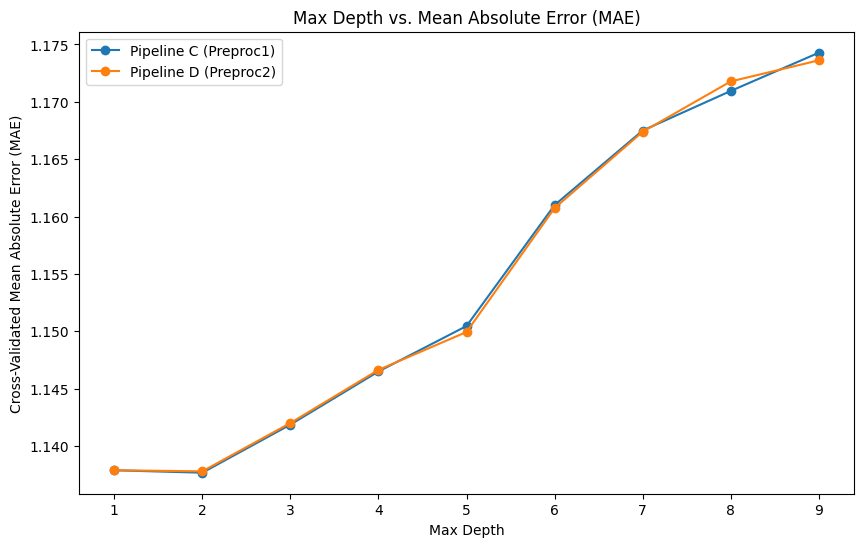

In [74]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score
# import matplotlib.pyplot as plt

# Define a range of max_depth values to evaluate
max_depth_range = range(1, 10)
errors_C, errors_D = [], []

# Loop through each max_depth and evaluate for both Pipeline C and Pipeline D
for depth in max_depth_range:
    # Update the Random Forest regressor in each pipeline with the current max_depth
    pipeline_C.set_params(regressor__max_depth=depth)
    pipeline_D.set_params(regressor__max_depth=depth)
    
    # Perform cross-validation on each pipeline and compute mean MAE
    mae_scores_C = -cross_val_score(pipeline_C, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_scores_D = -cross_val_score(pipeline_D, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    # Store the average MAE across folds for each depth
    errors_C.append(mae_scores_C.mean())
    errors_D.append(mae_scores_D.mean())

# Plot max_depth vs. MAE for both pipelines
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, errors_C, label="Pipeline C (Preproc1)", marker='o')
plt.plot(max_depth_range, errors_D, label="Pipeline D (Preproc2)", marker='o')
plt.title("Max Depth vs. Mean Absolute Error (MAE)")
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validated Mean Absolute Error (MAE)")
plt.legend()
plt.show()


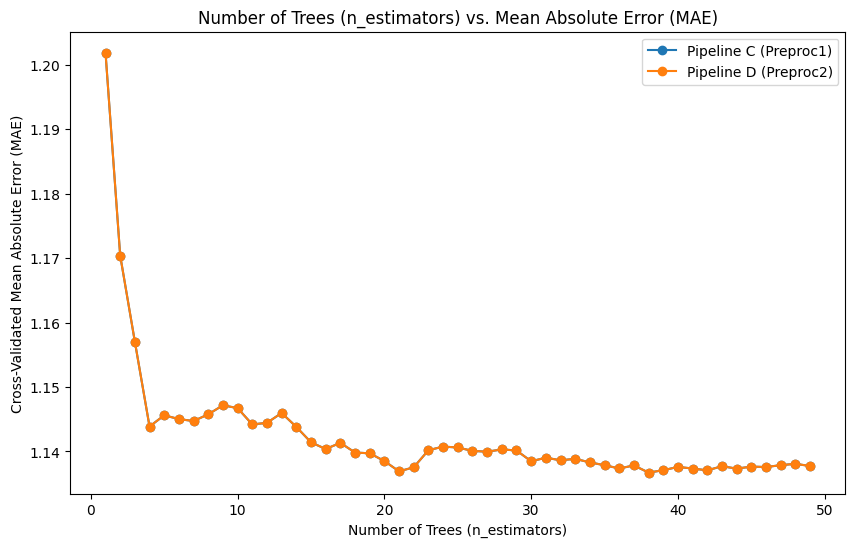

In [75]:
n_estimators_range = range(1, 50)
errors_C, errors_D = [], []

# Define the optimal max_depth from the previous step (replace with the determined value)
optimal_depth_C = 1  # Example value, adjust based on Step 1
optimal_depth_D = 1  # Example value, adjust based on Step 1

# Loop through each n_estimators and evaluate for both Pipeline C and Pipeline D
for n in n_estimators_range:
    # Set the max_depth and n_estimators parameters for each pipeline
    pipeline_C.set_params(regressor__max_depth=optimal_depth_C, regressor__n_estimators=n)
    pipeline_D.set_params(regressor__max_depth=optimal_depth_D, regressor__n_estimators=n)
    
    # Perform cross-validation to calculate MAE for each n_estimators
    mae_scores_C = -cross_val_score(pipeline_C, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_scores_D = -cross_val_score(pipeline_D, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    # Store average MAE for each n_estimators value
    errors_C.append(mae_scores_C.mean())
    errors_D.append(mae_scores_D.mean())

# Plot n_estimators vs. MAE for both pipelines
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, errors_C, label="Pipeline C (Preproc1)", marker='o')
plt.plot(n_estimators_range, errors_D, label="Pipeline D (Preproc2)", marker='o')
plt.title("Number of Trees (n_estimators) vs. Mean Absolute Error (MAE)")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Cross-Validated Mean Absolute Error (MAE)")
plt.legend()
plt.show()



# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [76]:
# Import necessary library: 
# from sklearn.model_selection import GridSearchCV


# Define parameter grids specific to each pipeline
param_grid_A = {'regressor__n_neighbors': [1, 5, 10, 15, 20, 25, 30]}      
param_grid_B = {'regressor__n_neighbors': [1, 5, 10, 15, 20, 25, 30]}      
param_grid_C = {'regressor__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8], 'regressor__max_depth': [None, 1, 2]}
param_grid_D = {'regressor__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8], 'regressor__max_depth': [None, 1, 2]}

*Comment:*
- As we're choosing KNN Regressor and Random Forest Regressor, the primary choice of performance metrics should be *MAE (mean absolute error)*. 
- Reason: 
    - KNN Regressor is *not* robust against outliers, if there are neighbours with very large or very small values, RMSE can sometimes exaggerate their influence in KNN predictions. 
    - MAE is suitable for both KNN Regressor and Random Forest Regressor, as it more fairly reflects the average performance across samples. 

In [77]:
# Define multiple metrics for evaluation, including R²
scoring_metrics = {'MAE': 'neg_mean_absolute_error', 'RMSE': 'neg_root_mean_squared_error', 'R2': 'r2'}

# Perform grid search for each pipeline with the specific parameter grid and multiple scoring metrics
grid_A = GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring=scoring_metrics, refit='MAE', n_jobs=-1)
grid_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring=scoring_metrics, refit='MAE', n_jobs=-1)
grid_C = GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring=scoring_metrics, refit='MAE', n_jobs=-1)
grid_D = GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring=scoring_metrics, refit='MAE', n_jobs=-1)



In [78]:
# Fit models 

print (f'Grid A')
grid_A.fit(X_train, y_train)


Grid A


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'day'], dtype='object'))])),
                                       ('regressor', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__n_neighbors': [1, 5, 10, 15, 20, 25, 30]},
             refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error', 'R2': 'r2',
                      'RMSE': 'neg_root_mean_squared_error'})

In [79]:
print (f'Grid B')
grid_B.fit(X_train, y_train)


Grid B


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('power',
                                                                                          PowerTransformer())]),
                                                                         Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'day'], dtype='object'))])),
                                       ('regressor', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__n_neighbors': [1, 5, 10, 15, 20, 25, 30]},
             refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error', 'R2': 'r2',
                      'RMSE': 'neg_root_mean_squared_error'})

In [80]:
print (f'Grid C')
grid_C.fit(X_train, y_train)

Grid C


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'day'], dtype='object'))])),
                                       ('regressor',
                                        RandomForestRegressor(max_depth=1,
                                                              n_estimators=49,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 1, 2],
                         'regressor__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8]},
             refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error', 'R2': 'r2',
                      'RMSE': 'neg_root_mean_squared_error'})

In [81]:
print (f'Grid D')
grid_D.fit(X_train, y_train)

Grid D


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('power',
                                                                                          PowerTransformer())]),
                                                                         Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['month', 'day'], dtype='object'))])),
                                       ('regressor',
                                        RandomForestRegressor(max_depth=1,
                                                              n_estimators=49,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 1, 2],
                         'regressor__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8]},
             refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error', 'R2': 'r2',
                      'RMSE': 'neg_root_mean_squared_error'})

# Evaluate

+ Which model has the best performance?

In [82]:
# Access and print results for MAE and RMSE
for label, grid in [("Grid A", grid_A), ("Grid B", grid_B), ("Grid C", grid_C), ("Grid D", grid_D)]:
    print(f"{label} Best Negative MAE Score: {grid.best_score_}")  

Grid A Best Negative MAE Score: -1.1400249694961555
Grid B Best Negative MAE Score: -1.1429735237383791
Grid C Best Negative MAE Score: -1.1438592886619972
Grid D Best Negative MAE Score: -1.1438592886619972


In [83]:
# Calculate best score across all pipelines and find the pipeline with the highest score
grids = [("Pipeline A", grid_A), ("Pipeline B", grid_B), ("Pipeline C", grid_C), ("Pipeline D", grid_D)]
best_name, best_grid = max(grids, key=lambda item: item[1].best_score_)
best_score = best_grid.best_score_

# Display the best pipeline, score, and parameters
print(f"Best Pipeline: {best_name}")
print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_grid.best_params_}")


Best Pipeline: Pipeline A
Best Score: -1.1400249694961555
Best Parameters: {'regressor__n_neighbors': 30}


In [84]:
# Convert Grid A's cv_results_ to a DataFrame
grid_A_cv_results = pd.DataFrame(grid_A.cv_results_)

# Display available columns to identify relevant ones
print(grid_A_cv_results.columns)

# Select and display relevant columns for analysis
selected_columns = [
    'param_regressor__n_neighbors',  # Hyperparameter for KNN (specific to grid_B)
    'mean_test_MAE', 'std_test_MAE', 
    'mean_test_RMSE', 'std_test_RMSE', 
    'mean_test_R2', 'std_test_R2',  # Corrected columns for R²
    'rank_test_MAE'
]

# Display sorted results by MAE rank (primary metric)
grid_A_cv_results[selected_columns].sort_values('rank_test_MAE')


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regressor__n_neighbors', 'params', 'split0_test_MAE',
       'split1_test_MAE', 'split2_test_MAE', 'split3_test_MAE',
       'split4_test_MAE', 'mean_test_MAE', 'std_test_MAE', 'rank_test_MAE',
       'split0_test_RMSE', 'split1_test_RMSE', 'split2_test_RMSE',
       'split3_test_RMSE', 'split4_test_RMSE', 'mean_test_RMSE',
       'std_test_RMSE', 'rank_test_RMSE', 'split0_test_R2', 'split1_test_R2',
       'split2_test_R2', 'split3_test_R2', 'split4_test_R2', 'mean_test_R2',
       'std_test_R2', 'rank_test_R2'],
      dtype='object')


,param_regressor__n_neighbors,mean_test_MAE,std_test_MAE,mean_test_RMSE,std_test_RMSE,mean_test_R2,std_test_R2,rank_test_MAE
6,30,-1.140025,0.045354,-1.376083,0.043466,-0.036157,0.038888,1
5,25,-1.142705,0.041426,-1.388760,0.043234,-0.055358,0.039596,2
4,20,-1.152997,0.034219,-1.403260,0.036269,-0.077482,0.030066,3
3,15,-1.166326,0.032899,-1.417974,0.035003,-0.100547,0.039430,4
2,10,-1.168417,0.038298,-1.432495,0.043787,-0.123860,0.063749,5
1,5,-1.199206,0.048940,-1.487855,0.051780,-0.212138,0.069378,6
0,1,-1.318209,0.157080,-1.869805,0.131503,-0.928699,0.320331,7


In [85]:
# Convert Grid C's cv_results_ to a DataFrame
grid_C_cv_results = pd.DataFrame(grid_C.cv_results_)

# Display available columns to identify relevant ones
print(grid_C_cv_results.columns)

# Select and display relevant columns for analysis
selected_columns = [
    'mean_test_MAE', 'std_test_MAE', 
    'mean_test_RMSE', 'std_test_RMSE', 
    'mean_test_R2', 'std_test_R2',  # Corrected columns for R²
    'rank_test_MAE'
]

# Display sorted results by MAE rank (primary metric)
grid_C_cv_results[selected_columns].sort_values('rank_test_MAE')

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regressor__max_depth', 'param_regressor__n_estimators', 'params',
       'split0_test_MAE', 'split1_test_MAE', 'split2_test_MAE',
       'split3_test_MAE', 'split4_test_MAE', 'mean_test_MAE', 'std_test_MAE',
       'rank_test_MAE', 'split0_test_RMSE', 'split1_test_RMSE',
       'split2_test_RMSE', 'split3_test_RMSE', 'split4_test_RMSE',
       'mean_test_RMSE', 'std_test_RMSE', 'rank_test_RMSE', 'split0_test_R2',
       'split1_test_R2', 'split2_test_R2', 'split3_test_R2', 'split4_test_R2',
       'mean_test_R2', 'std_test_R2', 'rank_test_R2'],
      dtype='object')


,mean_test_MAE,std_test_MAE,mean_test_RMSE,std_test_RMSE,mean_test_R2,std_test_R2,rank_test_MAE
11,-1.143859,0.039284,-1.368041,0.054959,-0.023317,0.036007,1
14,-1.144712,0.032986,-1.367707,0.053347,-0.022623,0.025797,2
13,-1.145014,0.034183,-1.367789,0.054117,-0.022821,0.030586,3
12,-1.145605,0.038978,-1.369755,0.053960,-0.025991,0.037328,4
15,-1.145754,0.032565,-1.368575,0.050553,-0.024008,0.022645,5
23,-1.149796,0.035956,-1.377736,0.051169,-0.037977,0.031726,6
22,-1.150717,0.038893,-1.377576,0.056182,-0.037492,0.033574,7
19,-1.150854,0.037736,-1.376377,0.054159,-0.035705,0.030079,8
21,-1.153133,0.044151,-1.379131,0.061392,-0.039872,0.043353,9
20,-1.155087,0.045961,-1.384036,0.059175,-0.047315,0.040494,10


In [86]:
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.model_selection import cross_val_predict

# Predict using cross-validation on the log-transformed model, then inverse transform
y_pred_log = cross_val_predict(best_model, X_test, y_test, cv=5)
y_pred = np.expm1(y_pred_log)  # Inverse log-transform the predictions
y_test_original = np.expm1(y_test)  # Inverse log-transform y_test for accurate comparison

# Calculate metrics on the original scale
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

# Display the results on the original scale
print("Evaluation Metrics on Original Scale (Inverse Log-Transformed):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Evaluation Metrics on Original Scale (Inverse Log-Transformed):
Mean Absolute Error (MAE): 8.717724031793516
Root Mean Squared Error (RMSE): 25.757741746654613
R-squared (R2): -0.07449670663046604


# Export

+ Save the best performing model to a pickle file.

In [87]:
import pickle

# Load the best KNN model pipeline from Grid A
best_model = grid_A.best_estimator_

# Save the entire best model pipeline to a file
with open('best_forest_fire_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

X has feature names, but KNeighborsRegressor was fitted without feature names


  0%|          | 0/103 [00:00<?, ?it/s]X has feature names, but KNeighborsRegressor was fitted without feature names
X has feature names, but KNeighborsRegressor was fitted without feature names
  1%|          | 1/103 [00:02<03:43,  2.20s/it]X has feature names, but KNeighborsRegressor was fitted without feature names
X has feature names, but KNeighborsRegressor was fitted without feature names
  2%|▏         | 2/103 [00:04<03:42,  2.20s/it]X has feature names, but KNeighborsRegressor was fitted without feature names
X has feature names, but KNeighborsRegressor was fitted without feature names
  3%|▎         | 3/103 [00:06<03:26,  2.06s/it]X has feature names, but KNeighborsRegressor was fitted without feature names
X has feature names, but KNeighborsRegressor was fitted without feature names
  4%|▍         | 4/103 [00:08<03:11,  1.94s/it]X has feature names, but KNeighborsRegressor was fitted without feature names
X has feature names, but KNeighborsRegressor was fitted without feature

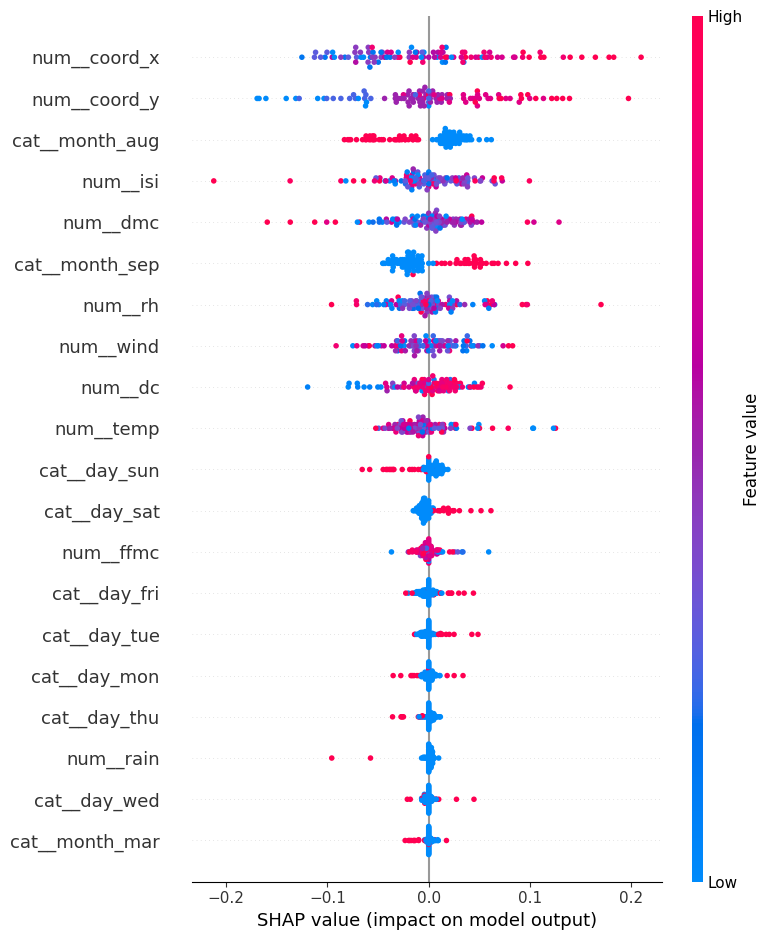

In [88]:
import pandas as pd
import shap

# Load the best KNN model pipeline from Grid A (trained on log-transformed target)
best_model = grid_A.best_estimator_

# Transform the test data and get feature names
data_transform = best_model.named_steps['preprocessing'].transform(X_test)
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Define a prediction wrapper for KernelExplainer (no inverse transformation here)
def pipeline_predict(data):
    # Ensure data is a DataFrame with transformed features
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=feature_names)
    # Use the log-scale predictions directly
    return best_model.named_steps['regressor'].predict(data)

# Use KernelExplainer for the KNN model
sample_data = pd.DataFrame(data_transform, columns=feature_names).sample(100, random_state=42)
explainer = shap.KernelExplainer(pipeline_predict, sample_data)
shap_values = explainer.shap_values(data_transform)

# Plot SHAP values
shap.summary_plot(shap_values, data_transform, feature_names=feature_names)


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


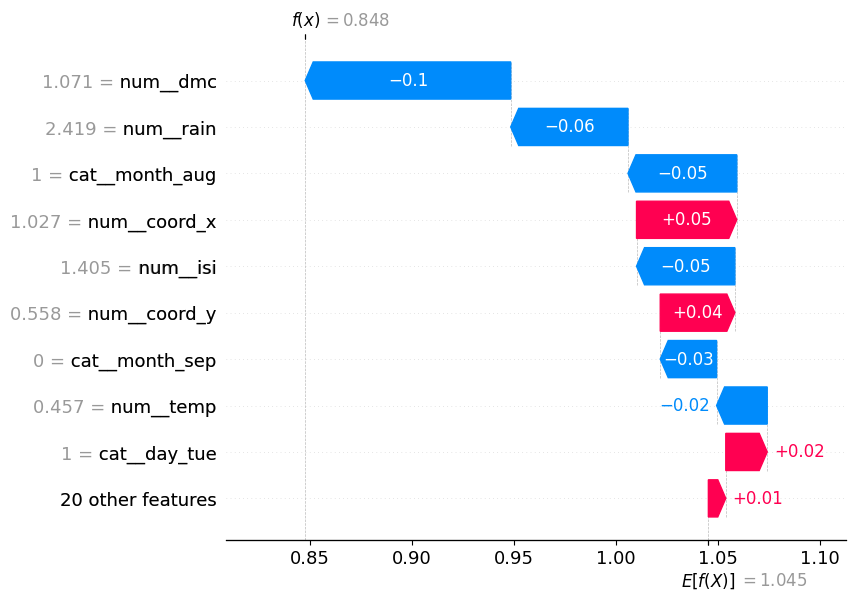

In [90]:
import shap

# Ensure the SHAP values and data_transform are aligned
shap_explanation = shap.Explanation(
    values=shap_values[1],                # SHAP values for a specific instance
    base_values=explainer.expected_value,  # Base value (expected prediction)
    data=data_transform[1],                # Transformed feature values for the same instance
    feature_names=feature_names            # Transformed feature names
)

# Plot the SHAP waterfall plot for the selected instance
shap.initjs()
shap.plots.waterfall(shap_explanation)


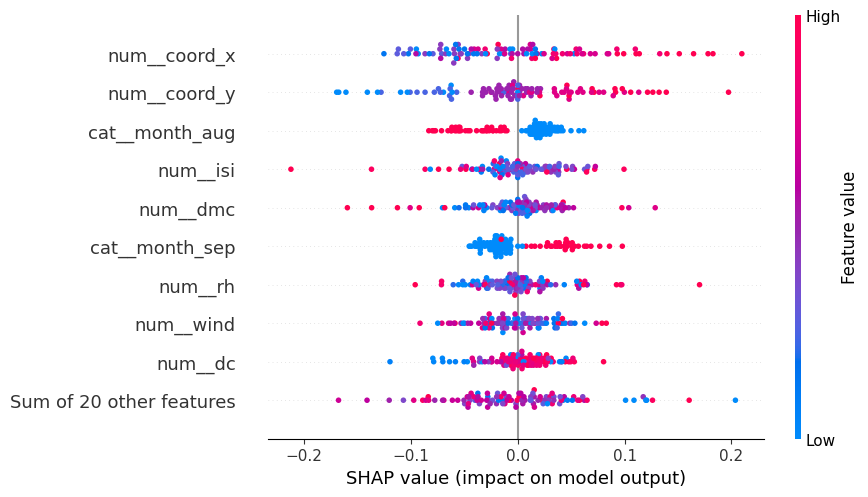

In [91]:
import shap

# Wrap the SHAP values in an Explanation object for the entire dataset
shap_explanation = shap.Explanation(
    values=shap_values,                  # SHAP values for all instances
    base_values=explainer.expected_value, # Base value (expected prediction)
    data=data_transform,                  # Transformed feature values for all instances
    feature_names=feature_names           # Transformed feature names
)

# Plot the SHAP beeswarm plot for global feature importance
shap.initjs()
shap.plots.beeswarm(shap_explanation)



Top Features from Random Forest in Grid C:
           Feature  Importance
5         num__isi        0.50
6        num__temp        0.25
8        num__wind        0.25
0     num__coord_x        0.00
16  cat__month_jun        0.00


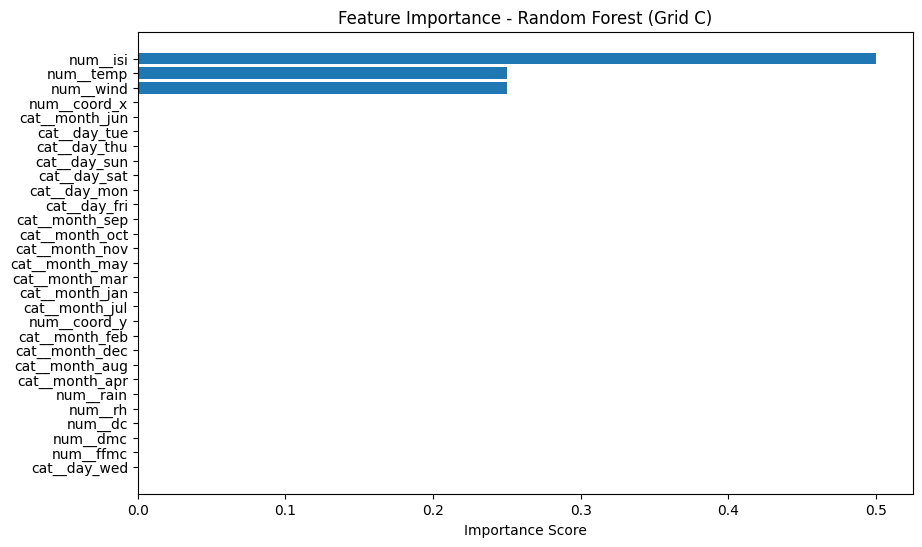

In [92]:
# Retrieve the best Random Forest model from grid C
best_rf_C = grid_C.best_estimator_.named_steps['regressor']

# Get feature names after preprocessing
feature_names = grid_C.best_estimator_.named_steps['preprocessing'].get_feature_names_out()

# Get feature importances from the best Random Forest model in grid C
feature_importance_C = best_rf_C.feature_importances_

# Create a DataFrame for better readability and sorting
importance_df_C = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_C
}).sort_values(by='Importance', ascending=False)

# Display top features for grid C
print("\nTop Features from Random Forest in Grid C:")
print(importance_df_C.head())

# Plot feature importance for Grid C
plt.figure(figsize=(10, 6))
plt.barh(importance_df_C['Feature'], importance_df_C['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.title("Feature Importance - Random Forest (Grid C)")
plt.xlabel("Importance Score")
plt.show()




*(Answer here.)*

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.